# CS544 - Health Informatics - Final Project

* Due 5/5/2025
* Professor Samantha Kleinberg
* Shreyoshi Ghosh & John Rizzo

## Initialization and Data Import

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

FILE_ROOT = '../data/mimic-iii-clinical-database-1.4/'
RANDOM_STATE=42

## Importing Data and Feature Engineering

In [3]:
# filtering on icd 9 codes

# Extract Transplant Patients from PROCEDURES_ICD
# Load ICD procedure codes and admissions
procedures = pd.read_csv(FILE_ROOT + "PROCEDURES_ICD.csv")
admissions = pd.read_csv(FILE_ROOT + "ADMISSIONS.csv")
patients = pd.read_csv(FILE_ROOT + "PATIENTS.csv")

# Identify transplant procedures — ICD-9 codes start with:
# '33' (lung), '41' (heart), '50' (liver/kidney), etc.
transplant_prefixes = ('33', '41', '50')
is_transplant = procedures['ICD9_CODE'].astype(str).str.startswith(transplant_prefixes)

# Extract transplant hospital admissions
transplant_hadm_ids = procedures[is_transplant]['HADM_ID'].unique()

# Join with ADMISSIONS and PATIENTS for demographics
transplant_df = admissions[admissions['HADM_ID'].isin(transplant_hadm_ids)]
transplant_df = transplant_df.merge(patients, on='SUBJECT_ID')

transplant_df.shape


(7950, 26)

In [4]:
# Feature Engineering — Demographics
# Age
transplant_df['ADMITTIME'] = pd.to_datetime(transplant_df['ADMITTIME'])
transplant_df['DOB'] = pd.to_datetime(transplant_df['DOB'])
transplant_df['AGE'] = transplant_df['ADMITTIME'].dt.year - transplant_df['DOB'].dt.year
transplant_df['AGE'] = transplant_df['AGE'].clip(lower=0, upper=100)  # handle edge cases

# Select features
features = transplant_df[['HADM_ID', 'SUBJECT_ID', 'AGE', 'GENDER', 'ETHNICITY']].copy()
features = pd.get_dummies(features, columns=['GENDER', 'ETHNICITY'], drop_first=True)


In [5]:
# demographics 
patients = pd.read_csv(FILE_ROOT + "PATIENTS.csv", usecols=["SUBJECT_ID", "GENDER", "DOB"])
admissions = pd.read_csv(FILE_ROOT + "ADMISSIONS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME", "ETHNICITY", "HOSPITAL_EXPIRE_FLAG"])

# Merge to transplant_df
#demo = transplant_df.merge(admissions, on=["SUBJECT_ID", "HADM_ID"], how="left").merge(patients, on="SUBJECT_ID", how="left")

In [6]:
# labs
labitems = pd.read_csv(FILE_ROOT + "D_LABITEMS.csv", usecols=["ITEMID", "LABEL"])
labs = pd.read_csv(FILE_ROOT + "LABEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ITEMID", "VALUENUM", "CHARTTIME"])

# Merge item labels
labs = labs.merge(labitems, on="ITEMID", how="left")

# Select common labs
common_labs = ['Creatinine', 'WBC', 'Hematocrit', 'Hemoglobin', 'Platelet Count', 'BUN', 'Sodium', 'Potassium']
labs = labs[labs["LABEL"].isin(common_labs)]

# Aggregate per admission (mean value per lab)
lab_features = labs.groupby(["HADM_ID", "LABEL"])["VALUENUM"].mean().unstack().reset_index()

In [7]:
# medications
meds = pd.read_csv(FILE_ROOT + "PRESCRIPTIONS.csv", usecols=["HADM_ID", "DRUG", "STARTDATE", "ENDDATE"])
meds["DRUG"] = meds["DRUG"].str.lower()

# Flag some relevant meds
med_keywords = ['tacrolimus', 'cyclosporine', 'mycophenolate', 'prednisone']
for med in med_keywords:
    meds[med] = meds["DRUG"].str.contains(med)

# Aggregate to HADM_ID
med_flags = meds.groupby("HADM_ID")[med_keywords].max().reset_index()

In [8]:
# merge
features = transplant_df[["SUBJECT_ID", "HADM_ID", "AGE", "HOSPITAL_EXPIRE_FLAG"] + 
                [col for col in transplant_df.columns if col.startswith("GENDER_") or col.startswith("ETHNICITY_")]]

for df in [lab_features, med_flags]:
    features = features.merge(df, on="HADM_ID", how="left")

features = features.fillna(0)

In [9]:
# using note events
notes = pd.read_csv(FILE_ROOT + "NOTEEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "TEXT", "CATEGORY"])

# Join with your transplant cohort
note_subset = notes[notes["HADM_ID"].isin(transplant_df["HADM_ID"])]

# Preprocess text
note_subset['TEXT'] = note_subset['TEXT'].str.lower().fillna('')

# Keyword flags

keywords = {
    'infection': ['infection', 'sepsis', 'fever'],
    'rejection': ['rejection', 'graft failure', 'dysfunction'],
    'surgical_complication': ['bleeding', 'dehiscence', 'anastomosis'],
}

for label, terms in keywords.items():
    pattern = '|'.join(terms)
    note_subset[label] = note_subset['TEXT'].str.contains(pattern, regex=True)

# Aggregate to HADM_ID level
note_features = note_subset.groupby("HADM_ID")[list(keywords.keys())].max().reset_index()

# Merge into features
features = features.merge(note_features, on="HADM_ID", how="left").fillna(0)

In [10]:
features

,SUBJECT_ID,HADM_ID,AGE,HOSPITAL_EXPIRE_FLAG,Creatinine,Hematocrit,Hemoglobin,Platelet Count,Potassium,Sodium,WBC,tacrolimus,cyclosporine,mycophenolate,prednisone,infection,rejection,surgical_complication
0,31,128652,72,1,0.850000,28.945455,10.030000,191.818182,4.176923,135.166667,2.0,False,False,False,False,True,False,False
1,32,175413,46,0,1.156250,33.640000,11.312500,434.000000,4.168421,137.625000,0.0,0,0,0,0,False,False,False
2,38,185910,76,0,1.108571,29.436842,10.035294,117.906250,4.085366,138.675676,0.0,False,False,False,False,True,False,True
3,41,101757,56,0,0.478571,27.365625,9.759375,400.178571,4.382143,132.321429,0.0,False,False,False,False,True,False,True
4,357,174486,62,0,0.836585,30.236986,10.736957,150.525000,4.054348,138.761905,2.0,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7945,95403,158136,68,0,0.820000,35.057143,11.571429,392.642857,3.815000,140.500000,0.0,False,False,False,True,True,False,True
7946,95404,134147,37,0,0.509756,31.348387,10.803125,469.838710,3.966071,138.482143,0.0,False,False,False,True,True,True,True
7947,95413,187979,56,0,0.725000,34.825000,11.725000,228.000000,3.900000,141.000000,6.0,False,False,False,False,True,False,False
7948,98666,161654,53,0,0.412821,27.664706,9.126471,319.176471,3.907317,140.025641,4.5,False,False,False,True,True,True,True


## Clustering into Risk Groups

In [11]:
#  Clustering into 2 Risk Groups
X_clust = features.drop(columns=['HADM_ID', 'SUBJECT_ID'], errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
features['complication_label'] = kmeans.fit_predict(X_scaled)


In [12]:
# Classification to Predict Risk Group
# f1 score is probably so high because im creating the complication label using clustering 

X = features.drop(columns=['HADM_ID', 'SUBJECT_ID', 'complication_label'], errors='ignore')
y = features['complication_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

clf = RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [13]:
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


F1 Score: 0.995
Accuracy Score: 0.9991614255765199
[[2167    2]
 [   0  216]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169
           1       0.99      1.00      1.00       216

    accuracy                           1.00      2385
   macro avg       1.00      1.00      1.00      2385
weighted avg       1.00      1.00      1.00      2385



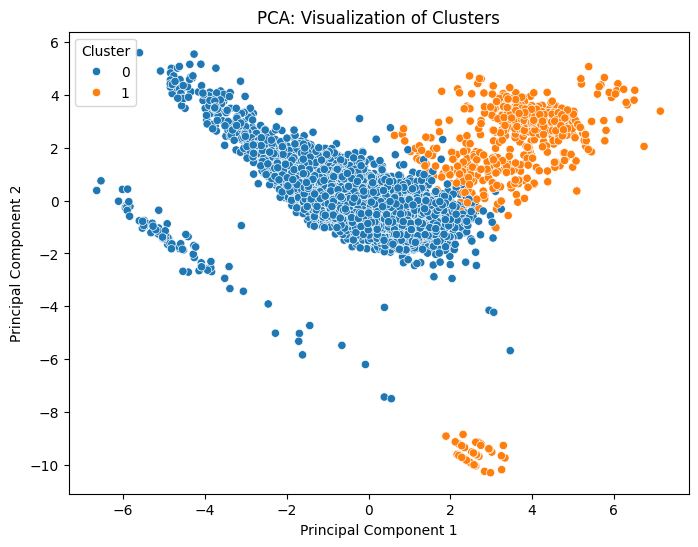

In [14]:
# PCA Plot of Clusters
# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to DataFrame
viz_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
viz_df['Cluster'] = features['complication_label'].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=viz_df, x='PC1', y='PC2', hue='Cluster')
plt.title('PCA: Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


## Examining Lab Values Across Clusters

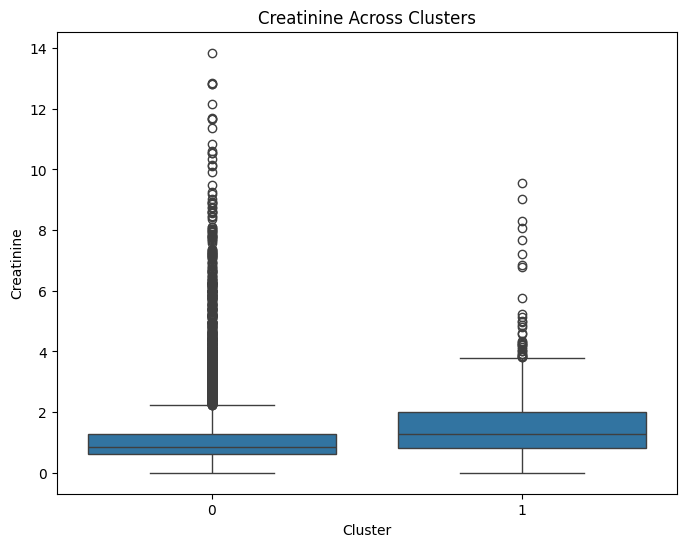

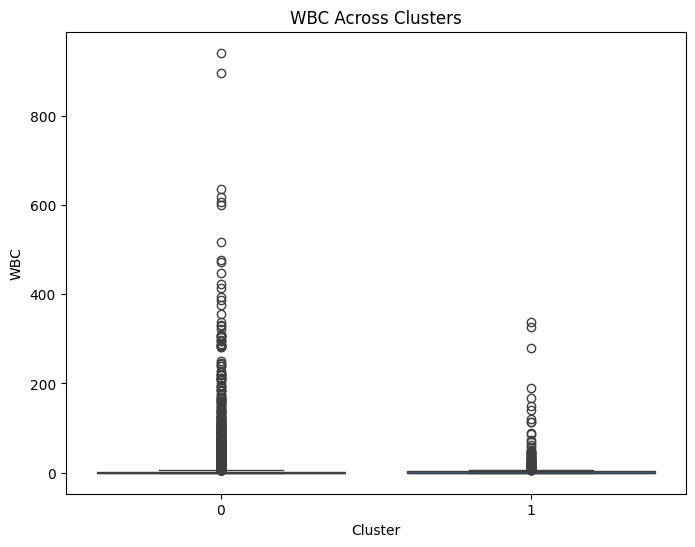

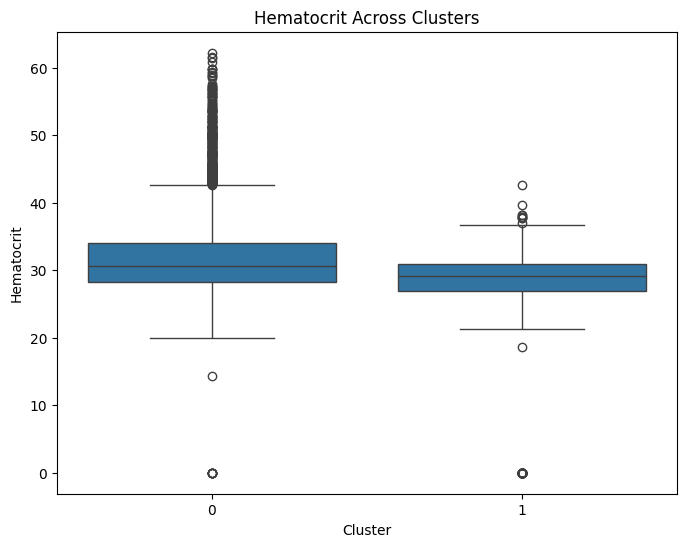

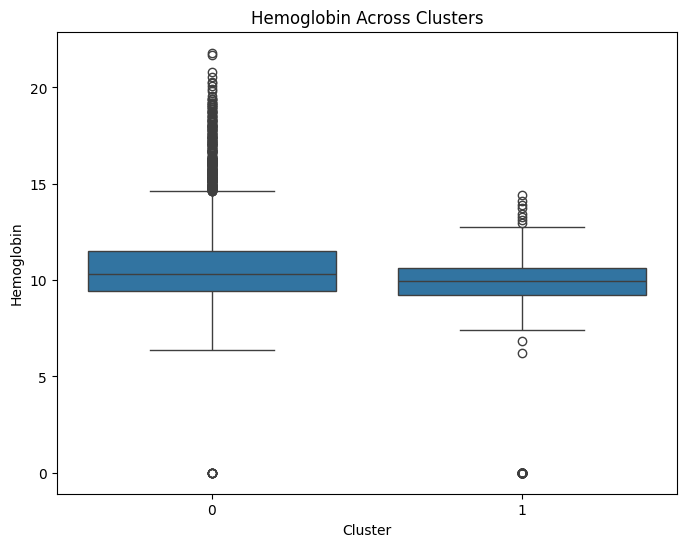

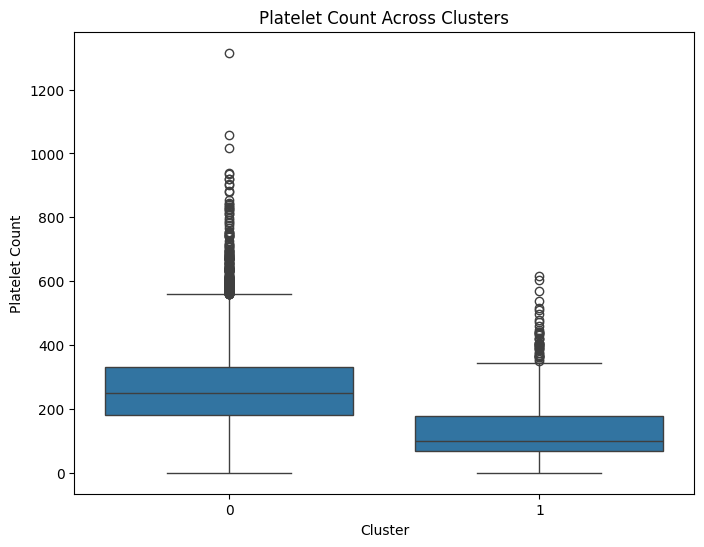

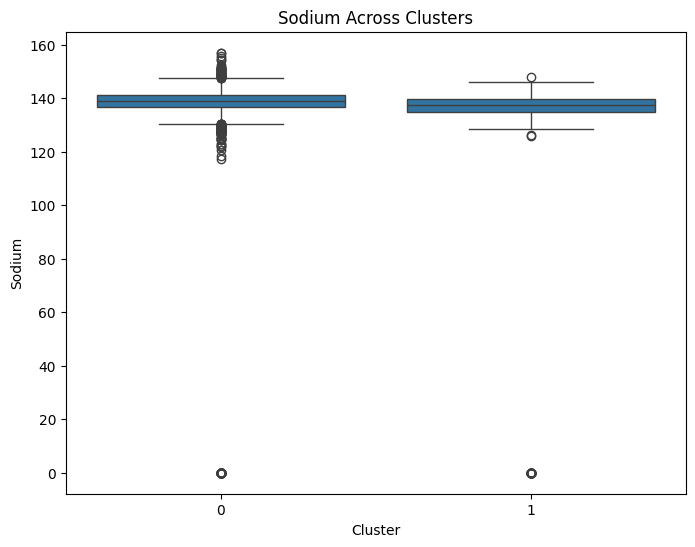

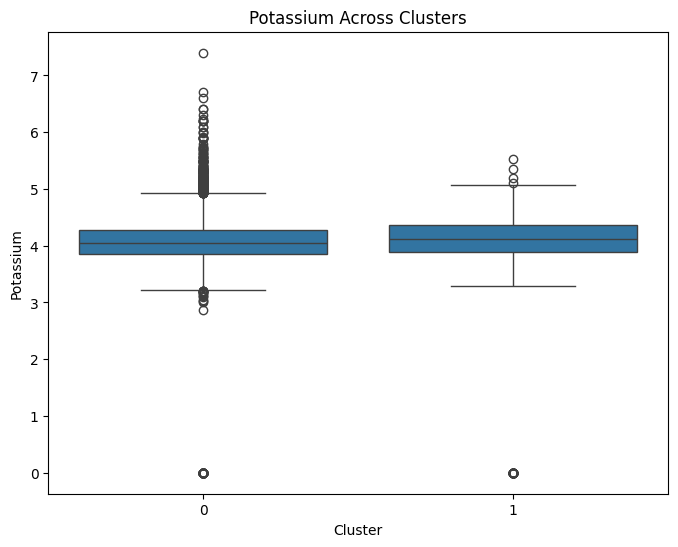

In [15]:
lab_values = ['Creatinine', 'WBC', 'Hematocrit', 'Hemoglobin', 'Platelet Count', 'Sodium', 'Potassium']

for lab in lab_values:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='complication_label', y=lab, data=features)
    plt.title(f"{lab} Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel(lab)
    plt.show()


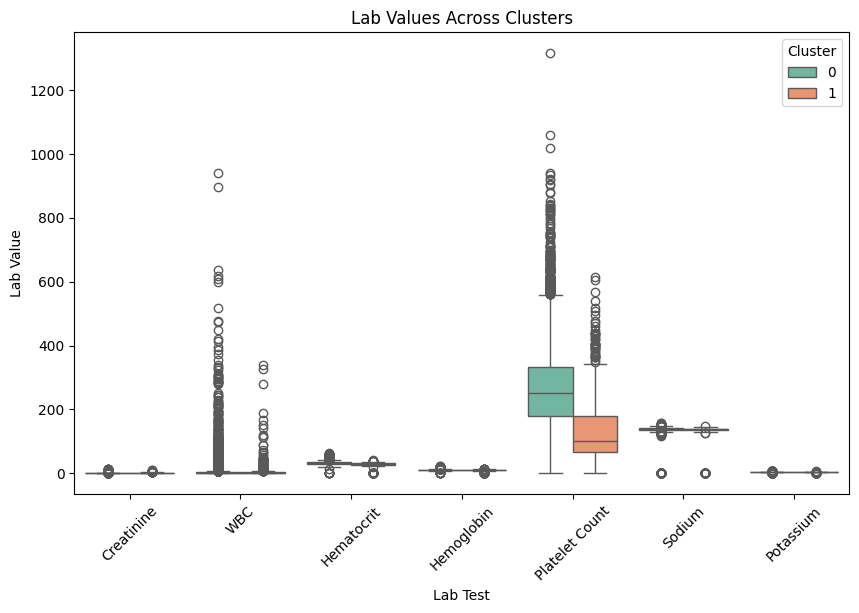

In [16]:
# Reshape the lab values data for combined boxplot
lab_values = ['Creatinine', 'WBC', 'Hematocrit', 'Hemoglobin', 'Platelet Count', 'Sodium', 'Potassium']

# Select the relevant lab columns and melt the dataframe
lab_data = features[['complication_label'] + lab_values]
lab_data = lab_data.melt(id_vars=['complication_label'], value_vars=lab_values, var_name='Lab', value_name='Value')

# Plot the combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lab', y='Value', hue='complication_label', data=lab_data, palette='Set2')
plt.title("Lab Values Across Clusters")
plt.xlabel("Lab Test")
plt.ylabel("Lab Value")
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


## Examining Medication Across Clusters

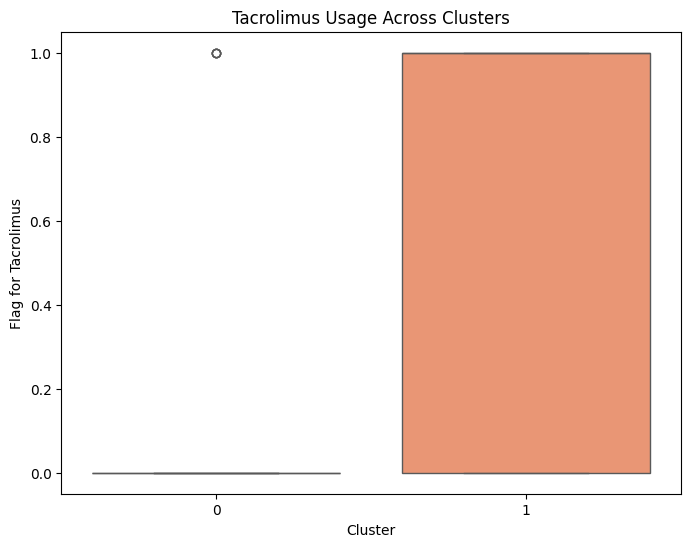

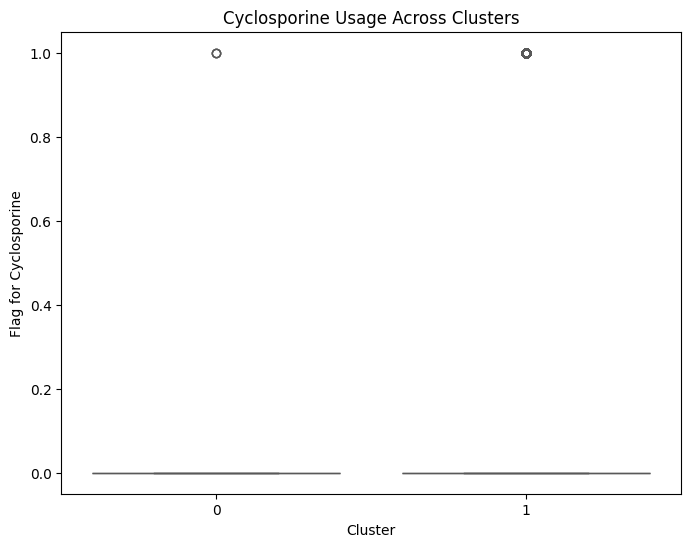

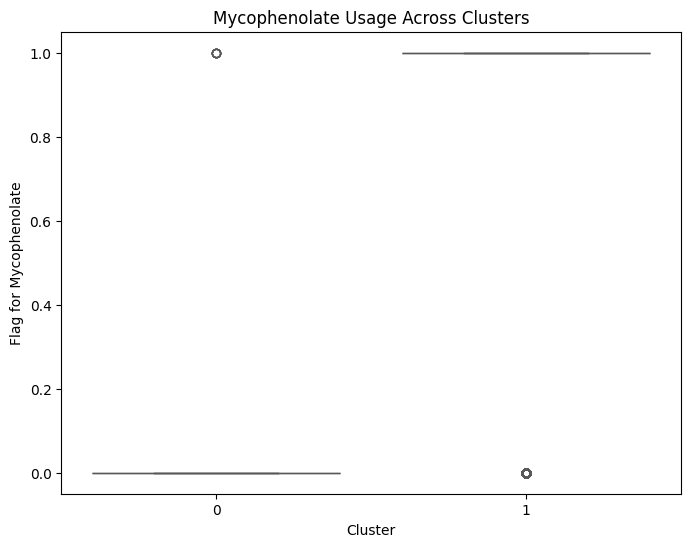

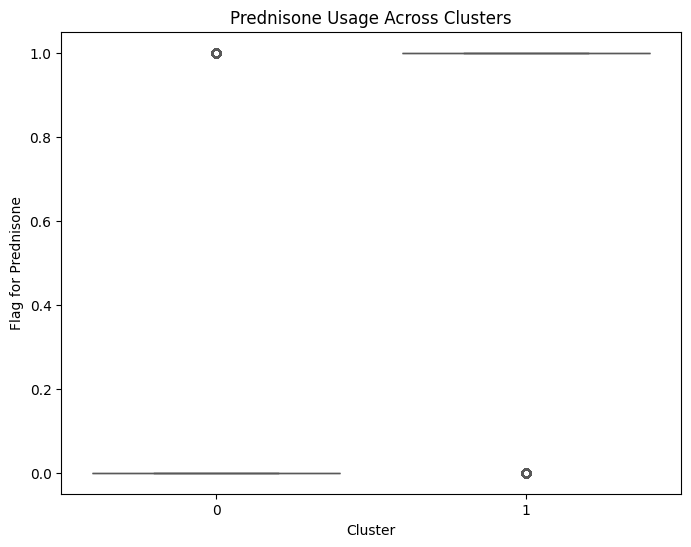

In [17]:
# Boxplots of Medication Usage Across Clusters
medications = ['tacrolimus', 'cyclosporine', 'mycophenolate', 'prednisone']

for med in medications:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='complication_label', y=med, data=features, palette='Set2')
    plt.title(f"{med.capitalize()} Usage Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel(f"Flag for {med.capitalize()}")
    plt.show()


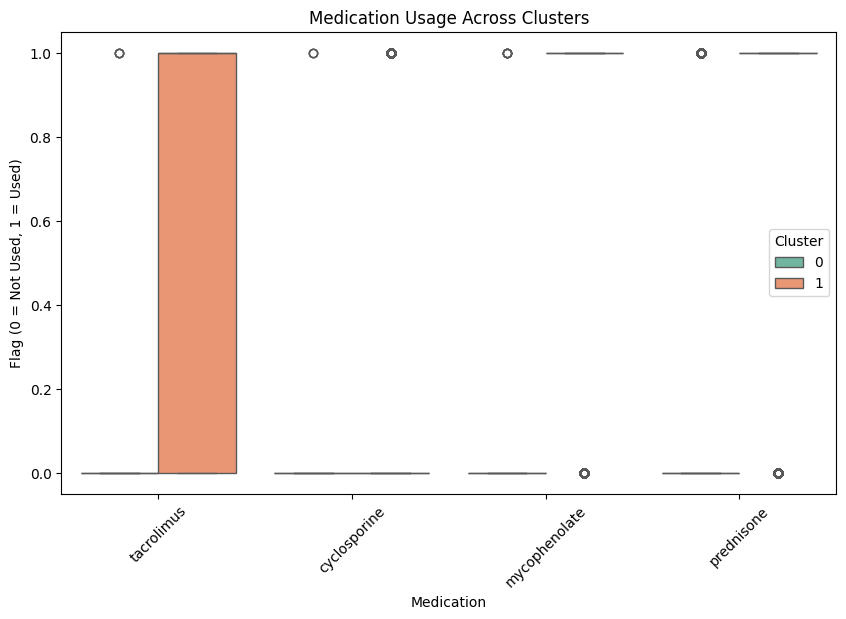

In [18]:
# Reshape the medication data for combined boxplot
medications = ['tacrolimus', 'cyclosporine', 'mycophenolate', 'prednisone']

# Select the relevant medication columns and melt the dataframe
med_data = features[['complication_label'] + medications]
med_data = med_data.melt(id_vars=['complication_label'], value_vars=medications, var_name='Medication', value_name='Flag')

# Plot the combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Medication', y='Flag', hue='complication_label', data=med_data, palette='Set2')
plt.title("Medication Usage Across Clusters")
plt.xlabel("Medication")
plt.ylabel("Flag (0 = Not Used, 1 = Used)")
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


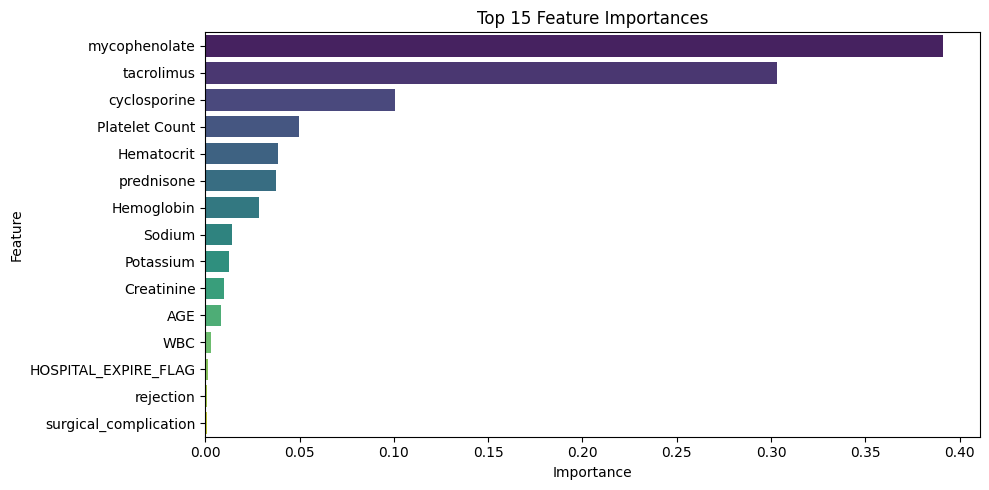

In [19]:
importances = clf.feature_importances_
feat_names = X.columns
forest_importance = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=forest_importance[:15].values, y=forest_importance[:15].index, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()